Note: We are unable to execute all cells, due to the large amount of time it takes, and that there are frequent crashes during the execution of cells when we run them on our own environment

## Importing all necessary libraries

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split

from skimage.feature import hog
from cv2 import HOGDescriptor


from skimage.feature import daisy

import cv2
from cv2 import INTER_CUBIC
from cv2 import resize as _resize

import matplotlib.pyplot as plt

import pickle
import json

In [2]:
# Intel chips, used for cpu acceleration

# Installation
# !pip install scikit-learn-intelex

from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
# Linux/WSL, used for gpu acceleration

# Installation
# conda create -n rapids-24.04 -c rapidsai -c conda-forge -c nvidia rapids=24.04 python=3.11 cuda-version=12.2

from cuml.svm import SVC 

## Global params

In [4]:
SEED = 69
FULL = False

## Reading Data

In [5]:
def read_data(mode="train", p=0.2, augment=False, seed=None):
    """
    Read the training/testing files and return the input data and labels.

    Parameters:
    ----------
    mode (str): 'train' or 'test' to read the training or testing data.
    p (float): fraction of the data to read. Useful for debugging.
    seed (int): random seed to use for reproducibility.
    augment (bool): whether or not to augment

    Returns:
    -------
    X (np.array): input data
    y (np.array): labels
    """
    if mode == "train" or mode == "test":
        data = pd.read_csv('train.csv')
        mode = "train"
    elif mode == "predict":
        data = pd.read_csv('test.csv')
        mode = "test"
    else:
        raise ValueError("mode must be 'train' or 'test' or 'predict'")

    if mode != "test":
        if seed is None:data = data.sample(frac=p)
        else: data = data.sample(frac=p, random_state=seed)

    X = data['im_name'].apply(lambda filename: np.asarray(Image.open(f"{mode}_ims/{filename}"))).values
    y = data['label'].values
    X = np.stack(X)
    if augment:
        X = np.concatenate([X, X[:, :, ::-1, :]])
        y = np.concatenate([y, y])

    return X, y

In [6]:
def predict_data(predictedLabels, fp='test.csv'):
    """
    Writes and predicts the testing files.

    Parameters:
    ----------
    predictedLabels (np.array): predicted labels for the testing data.
    fp (str): filepath to write the predicted labels.

    Returns:
    -------
    None
    """
    data = pd.read_csv('test.csv')
    data['label'] = predictedLabels
    data.to_csv(fp, index=False)

In [7]:
trainData, trainLabels = read_data("train", p=1, augment=True, seed=SEED)
testData = testLabels = np.zeros((1,1))
if not FULL: trainData, testData, trainLabels, testLabels = train_test_split(trainData, trainLabels, test_size=0.2, random_state=SEED)
print([sum(trainLabels == i) for i in range(10)])
trainData.shape, trainLabels.shape, testData.shape, testLabels.shape

[8050, 8054, 8086, 8022, 7990, 7939, 7907, 7966, 8045, 7941]


((80000, 32, 32, 3), (80000,), (20000, 32, 32, 3), (20000,))

In [8]:
predictData, predictLabels = read_data("predict", p=1)
predictData.shape, predictLabels.shape

((10000, 32, 32, 3), (10000,))

## Feature Extraction

### Resizing (32, 32) -> (128, 128)

In [9]:
def resize(imgs): return np.array([_resize(img, (128, 128), interpolation=INTER_CUBIC) for img in imgs])

In [10]:
trainData_large = resize(trainData)
testData_large = resize(testData) if not FULL else np.zeros((1, 1))
predictData_large = resize(predictData)
trainData_large.shape, testData_large.shape, predictData_large.shape

((80000, 128, 128, 3), (20000, 128, 128, 3), (10000, 128, 128, 3))

### HOG Feature extraction

In [11]:
def hog_features(data, visualize=False, type='cv2'):
    assert type in ['sklearn', 'cv2'], "type must be 'sklearn' or 'cv2'"
    if type == 'sklearn':
        # slow + suboptimal (used on 32x32)
        _hog_kwargs = {
            "block_norm": 'L2-Hys',
            "orientations": 10,
            "pixels_per_cell": (4, 4),
            "cells_per_block": (3, 3),
            "channel_axis": -1
        }
        if visualize: 
            _hogs = [hog(img, **_hog_kwargs, visualize=True) for img in data]
            _hogFeatures = np.array([_hog[0] for _hog in _hogs])
            _hogImgs = np.array([_hog[1] for _hog in _hogs])
            return _hogFeatures, _hogImgs
        else:
            return np.array([hog(img.reshape(32, 32, 3), **_hog_kwargs) for img in data])
    else:
        assert visualize == False, "visualize is not supported for type='cv2'"
        # Following params is found to be optimal for CIFAR-10 dataset
        _hog_kwargs = {
            "_winSize": (128, 128),
            "_blockSize": (64, 64),
            "_blockStride": (16, 16),
            "_cellSize": (16, 16),
            "_nbins": 10,
            "_derivAperture": 1,
            "_winSigma": -1,
            "_histogramNormType": 0,
            "_L2HysThreshold": 0.2,
            "_gammaCorrection": True,
            "_nlevels": 64,
            "_signedGradient": True
        }
        _hog = HOGDescriptor(**_hog_kwargs)
        return np.array([_hog.compute(img) for img in data])

trainData_hog = hog_features(trainData_large)
testData_hog = hog_features(testData_large) if not FULL else np.zeros((1, 1))
predictData_hog = hog_features(predictData_large)
trainData_hog.shape, testData_hog.shape, predictData_hog.shape

((80000, 4000), (20000, 4000), (10000, 4000))

In [12]:
del trainData_large, testData_large, predictData_large

### Daisy Features

In [13]:
def daisy_features(data, visualize=False):
    _daisy_kwargs = {
        "step": 7,
        "radius": 7,
        "rings": 1,
        "histograms": 6,
        "orientations": 8,
        "normalization": "l2"
    }
    if data.ndim == 1: data = data.reshape(1, -1)
    data = np.array([np.dot(img[...,:3], [0.2989, 0.5870, 0.1140]) for img in data])
    if visualize:
        _daisyImgs = np.array([daisy(img, **_daisy_kwargs) for img in data])
        return _daisyImgs
    else:
        return np.array([daisy(img, **_daisy_kwargs).flatten() for img in data])

trainData_daisy = daisy_features(trainData)
testData_daisy = daisy_features(testData) if not FULL else np.zeros((1, 1))
predictData_daisy = daisy_features(predictData)
trainData_daisy.shape, testData_daisy.shape, predictData_daisy.shape

((80000, 504), (20000, 504), (10000, 504))

### EOH (Edge Orientation Histograms)

In [14]:
def eoh(img, num_bins=9, cell_size=8):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    angle = np.arctan2(sobely, sobelx)
    angle = np.rad2deg(angle) % 360
    num_cells_x = img.shape[1] // cell_size
    num_cells_y = img.shape[0] // cell_size
    histograms = []
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            cell_magnitude = magnitude[i * cell_size: (i + 1) * cell_size,
                                       j * cell_size: (j + 1) * cell_size]
            cell_angle = angle[i * cell_size: (i + 1) * cell_size,
                               j * cell_size: (j + 1) * cell_size]
            histogram, _ = np.histogram(cell_angle,
                                        bins=num_bins,
                                        range=(0, 360),
                                        weights=cell_magnitude)
            histograms.append(histogram)
    _eoh = np.concatenate(histograms)
    _eoh /= np.linalg.norm(_eoh)
    return _eoh

def eoh_features(data):
    _eoh_kwargs = {
        "num_bins": 17,
        "cell_size": 6
    }
    if data.ndim == 1: data = data.reshape(1, -1)
    data = np.array([np.dot(img.reshape(32, 32, 3)[...,:3], [0.2989, 0.5870, 0.1140]) for img in data])
    return np.array([eoh(img, **_eoh_kwargs).flatten() for img in data])

trainData_eoh = eoh_features(trainData)
testData_eoh = eoh_features(testData) if not FULL else np.zeros((1, 1))
predictData_eoh = eoh_features(predictData)
trainData_eoh.shape, testData_eoh.shape, predictData_eoh.shape

((80000, 425), (20000, 425), (10000, 425))

### Blurring

In [15]:
def blur(imgs, kernelSize=4):
    assert 32 % kernelSize == 0, "Kernel size must be a factor of 32"
    if imgs.ndim == 1: return np.mean(imgs.reshape(32, 32, 3).reshape(32//kernelSize, kernelSize, 32//kernelSize, kernelSize, 3), axis=(1, 3)).reshape(32//kernelSize * 32//kernelSize * 3)/255
    else: return np.mean(imgs.reshape(-1, 32, 32, 3).reshape(-1, 32//kernelSize, kernelSize, 32//kernelSize, kernelSize, 3), axis=(2, 4)).reshape(-1, 32//kernelSize * 32//kernelSize * 3)/255

trainData_blurred4x4 = blur(trainData)
testData_blurred4x4 = blur(testData) if not FULL else np.zeros((1, 1))
predictData_blurred4x4 = blur(predictData)
trainData_blurred4x4.shape, testData_blurred4x4.shape, predictData_blurred4x4.shape

((80000, 192), (20000, 192), (10000, 192))

### HOG + Daisy + EOH + Blurred

In [16]:
trainData_hb4x4 = np.hstack([trainData_hog, trainData_daisy, trainData_eoh, trainData_blurred4x4]).astype(np.float32)
testData_hb4x4 = np.hstack([testData_hog, testData_daisy, testData_eoh, testData_blurred4x4]).astype(np.float32) if not FULL else np.zeros((1, 1))
predictData_hb4x4 = np.hstack([predictData_hog, predictData_daisy, predictData_eoh, predictData_blurred4x4]).astype(np.float32)
trainData_hb4x4.shape, testData_hb4x4.shape, predictData_hb4x4.shape

((80000, 5121), (20000, 5121), (10000, 5121))

### Normalizing

In [17]:
def normalize(data, trainData): return (data - np.min(trainData, axis=0))/(np.max(trainData, axis=0) - np.min(trainData, axis=0))
trainData_std_hb4x4 = normalize(trainData_hb4x4, trainData_hb4x4)
testData_std_hb4x4 = normalize(testData_hb4x4, trainData_hb4x4) if not FULL else np.zeros((1, 1))
predictData_std_hb4x4 = normalize(predictData_hb4x4, trainData_hb4x4)
trainData_std_hb4x4.shape, testData_std_hb4x4.shape, predictData_std_hb4x4.shape

((80000, 5121), (20000, 5121), (10000, 5121))

## Free some memory first

In [18]:
del trainData_hb4x4, testData_hb4x4, predictData_hb4x4

In [19]:
del trainData_hog, testData_hog, predictData_hog

In [20]:
del trainData_daisy, testData_daisy, predictData_daisy, trainData_eoh, testData_eoh, predictData_eoh, trainData_blurred4x4, testData_blurred4x4, predictData_blurred4x4

## Using LDA to encode the data

In [21]:
def softmax(output):
    return np.exp(output) / np.sum(np.exp(output), axis=1).reshape(-1, 1)

In [22]:
class LDA_encoder():
    # KNN can be used on this
    def __init__(self, ndim):
        self.ndim = ndim
        self._lda = LinearDiscriminantAnalysis(n_components=ndim)
        self.classCenters = None
        self.trainPoints = None
    def fit(self, X, y):
        self.trainPoints = self._lda.fit_transform(X, y)
        self.classCenters = np.array([np.mean(self.trainPoints[y == i], axis=0) for i in np.unique(y)])
    def encode(self, X, type='distance'):
        _X = self._lda.transform(X)
        if type == 'distance':
            return 1/np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T
    def predict(self, X, prob=False, type='distance'):
        _X = self._lda.transform(X)
        if type == 'distance':
            if prob:
                return softmax(1/np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T)
            else:
                return np.argmin(np.array([np.linalg.norm(_X - center, axis=1) for center in self.classCenters]).T, axis=1)

In [23]:
del trainData

In [24]:
del testData, predictData

In [ ]:
lda_std_encoder = LDA_encoder(9)
lda_std_encoder.fit(trainData_std_hb4x4, trainLabels)

## Training SVM model

In [24]:
trainData_hb4x4_withEncodedDistance_std = np.hstack([trainData_std_hb4x4, lda_std_encoder.encode(trainData_std_hb4x4)])
testData_hb4x4_withEncodedDistance_std = np.hstack([testData_std_hb4x4, lda_std_encoder.encode(testData_std_hb4x4)]) if not FULL else np.zeros((1, 1))
predictData_hb4x4_withEncodedDistance_std = np.hstack([predictData_std_hb4x4, lda_std_encoder.encode(predictData_std_hb4x4)])
trainData_hb4x4_withEncodedDistance_std.shape, testData_hb4x4_withEncodedDistance_std.shape

((80000, 5131), (20000, 5131))

In [25]:
del trainData_std_hb4x4, testData_std_hb4x4, predictData_std_hb4x4

In [26]:
del lda_std_encoder

### Fine Tuning

In [39]:
def computeTestAcc(p, trainData, trainLabels, testData, testLabels):
    svm_ft = SVC(C=10**p, kernel='rbf', gamma='scale')
    svm_ft.fit(trainData, trainLabels)
    score = svm_ft.score(testData, testLabels)
    del svm_ft, trainData, trainLabels, testData, testLabels
    return score

In [40]:
# Feel free to tune, found C=7 (approximately) to be the best
# No need to execute this cell

## We have not finished execution due to a crash, thus we provide the partially ran ouput
## And we cannot re-run due to the time limitations, however this is tested on a RTX 4090 and we can confire it does not output any bugs

a, b = 0, 2
precision = 0.1
phi = (np.sqrt(5)-1)/2
subset = 10000

l = a + (1-phi)*(b-a)
r = a + phi*(b-a)
fl = computeTestAcc(l, trainData_hb4x4_withEncodedDistance_std[:subset], trainLabels[:subset], trainData_hb4x4_withEncodedDistance_std[80000:], trainLabels[80000:])
fr = computeTestAcc(r, trainData_hb4x4_withEncodedDistance_std[:subset], trainLabels[:subset], trainData_hb4x4_withEncodedDistance_std[80000:], trainLabels[80000:])

iter = 0

print(f"Initializations, intial interval: [{a:.4f}, {b:.4f}], precision: {b-a:.4f}, optimal C: {10**((b+a)/2):.4f} +/- {10**b-10**((b+a)/2):.4f}, left: {fl:.4f}, right: {fr:.4f}")

while b - a > precision:
    if fl < fr:
        a = l
        l = r
        fl = fr
        r = a + phi*(b-a)
        fr = computeTestAcc(r, trainData_hb4x4_withEncodedDistance_std[:subset], trainLabels[:subset], trainData_hb4x4_withEncodedDistance_std[80000:], trainLabels[80000:])
    else:
        b = r
        r = l
        fr = fl
        l = a + (1-phi)*(b-a)
        fl = computeTestAcc(l, trainData_hb4x4_withEncodedDistance_std[:subset], trainLabels[:subset], trainData_hb4x4_withEncodedDistance_std[80000:], trainLabels[80000:])
    iter += 1
    print(f"Iteration {iter}, interval: [{a:.4f}, {b:.4f}], precision: {b-a:.4f}, optimal C: {10**((b+a)/2):.4f} +/- {10**b-10**((b+a)/2):.4f}, left: {fl:.4f}, right: {fr:.4f}")

optimalC = 10**((b+a)/2)
print(f"Optimal C: {optimalC:.4f} +/- {10**b-optimalC:.4f}")

Initializations, intial interval: [0.0000, 2.0000], precision: 2.0000, optimal C: 10.0000 +/- 90.0000, left: 0.6812, right: 0.6817
Iteration 1, interval: [0.7639, 2.0000], precision: 1.2361, optimal C: 24.0972 +/- 75.9028, left: 0.6817, right: 0.6817
Iteration 2, interval: [0.7639, 1.5279], precision: 0.7639, optimal C: 13.9926 +/- 19.7256, left: 0.6817, right: 0.6817
Iteration 3, interval: [0.7639, 1.2361], precision: 0.4721, optimal C: 10.0000 +/- 7.2214, left: 0.6817, right: 0.6817
Iteration 4, interval: [0.7639, 1.0557], precision: 0.2918, optimal C: 8.1251 +/- 3.2440, left: 0.6819, right: 0.6817
Iteration 5, interval: [0.7639, 0.9443], precision: 0.1803, optimal C: 7.1466 +/- 1.6491, left: 0.6819, right: 0.6819
Iteration 6, interval: [0.7639, 0.8754], precision: 0.1115, optimal C: 6.6018 +/- 0.9039, left: 0.6814, right: 0.6819


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /__w/cuml/cuml/python/build/cp310-cp310-manylinux_2_17_x86_64/_deps/rmm-src/include/rmm/mr/device/cuda_memory_resource.hpp:60: cudaErrorMemoryAllocation out of memory

In [ ]:
svc_std = SVC(C=7, kernel='rbf', gamma='scale')
svc_std.fit(trainData_hb4x4_withEncodedDistance_std, trainLabels)

### Prediction

In [ ]:
predictLabels = svc_std.predict(predictData_hb4x4_withEncodedDistance_std)
predictLabels.shape

(10000,)

In [ ]:
predictLabels[:10]

array([2, 3, 8, 7, 9, 6, 0, 5, 2, 9])

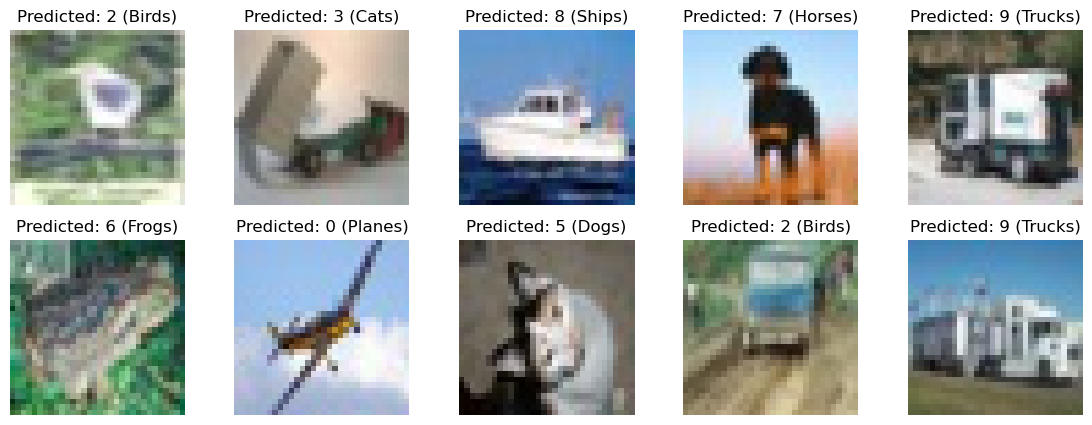

In [ ]:
i2label = ["Planes", "Cars", "Birds", "Cats", "Deers", "Dogs", "Frogs", "Horses", "Ships", "Trucks"]
fig, axs = plt.subplots(2, 5, figsize=(14, 5))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(predictData[i].reshape(32, 32, 3))
    ax.set_title(f"Predicted: {predictLabels[i]} ({i2label[predictLabels[i]]})")
    ax.axis('off')

In [ ]:
predict_data(predictLabels, fp='test-ResizedHOGDaisyEOH-LDA-SVC-ft.csv')

## Save & Load Model

In [ ]:
with open("ResizedHOG+Daisy+EOH+blur8x8+LDA+SVM_ftC=7.pkl", "wb") as file:
    pickle.dump(svc_std, file)

In [ ]:
with open("ResizedHOG+Daisy+EOH+blur8x8+LDA+SVM_ftC=7.pkl", "rb") as file:
    svc_std = pickle.load(file)